Take care of imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
import seaborn as sns
import scipy
import glob
import folium
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

###Load Taxi data set from big csv file

In [2]:
df = pd.read_csv('/Users/eladg/Documents/Git/NYC_Data_IPA/Taxi/allTaxiData.csv',
                dtype = {'pickup_day_of_year': np.uint16,
                         'pickup_day_of_Month': np.uint8, 'pickup_day_of_week': np.uint8,
                         'pickup_month': np.uint8, 'pickup_hour': np.uint8, 'passenger_count': np.uint8,
                        'trip_time_in_secs': np.uint16, 'trip_distance': np.float16, 'pickup_longitude': np.float,
                        'pickup_latitude': np.float, 'dropoff_longitude': np.float, 'dropoff_latitude': np.float},
                parse_dates = [0])

Do some cleaning

In [3]:
dfOrig = df
goodEntries = (df['trip_time_in_secs'] > 0) & (df['trip_time_in_secs'] < np.inf) & (df['trip_distance'] > 0) & (df['trip_distance'] < np.inf)
df = df[goodEntries]

goodEntries2 = (df[['trip_time_in_secs', 'trip_distance']].apply(zscore) < 10).all(axis=1)
df = df[goodEntries2]

Save data set to pickles (too big to save as one)

In [156]:
dfList = np.array_split(df,6)
ind = 0
for d in dfList:
    ind += 1
    d.to_pickle('allTaxiData' + str(ind) + '.pkl')

###Load data set directly from a bunch of pickles

In [59]:
def zscore(x):
    return (x - (x.astype(float)).mean())/(x.astype(float)).std() # I convert to float 64 to avoid overflow

fList = glob.glob('./allTaxiData*.pkl')
dfList = []
for file in fList:
    currDF = pd.read_pickle(file)
    # clean the data during the loading procedure to keep memory cost low
    goodEntries1 = (currDF[['trip_time_in_secs', 'trip_distance', 'pickup_latitude',
                           'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']] != 0).all(axis=1)
    goodEntries2 = (currDF[['trip_time_in_secs', 'trip_distance']] < np.inf).all(axis=1)
    currDF = currDF[goodEntries1 & goodEntries2]
    goodEntries3 = (currDF[['trip_time_in_secs', 'trip_distance']].apply(zscore) < 10).all(axis=1)
    currDF = currDF[goodEntries3]
    dfList.append(currDF)
    
df = pd.concat(dfList)

Take a look at the data

In [60]:
df.head()

,pickup_date,pickup_day_of_year,pickup_day_of_Month,pickup_day_of_week,pickup_month,pickup_hour,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2013-07-01 01:47:00,182,1,0,7,1,1,300,1.169922,-74.013229,40.714718,-74.003494,40.725285
1,2013-07-01 01:39:00,182,1,0,7,1,1,780,4.171875,-73.980865,40.763947,-73.933884,40.767677
2,2013-07-01 01:36:00,182,1,0,7,1,1,840,2.980469,-74.007568,40.740898,-73.980118,40.713985
3,2013-07-01 01:53:00,182,1,0,7,1,1,240,0.750000,-73.985466,40.718342,-73.982841,40.727016
4,2013-07-01 01:47:00,182,1,0,7,1,1,720,1.759766,-74.005630,40.726448,-74.003906,40.742031


Histogram Longitude

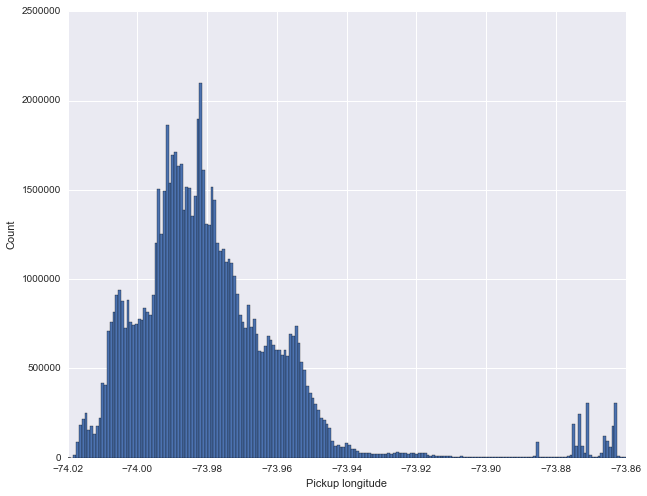

In [61]:
histBinsLo = np.linspace(-74.02,-73.86,200)
df['pickup_longitude'].hist(bins=histBinsLo)
plt.xlabel('Pickup longitude')
plt.ylabel('Count')

Histogram latitude

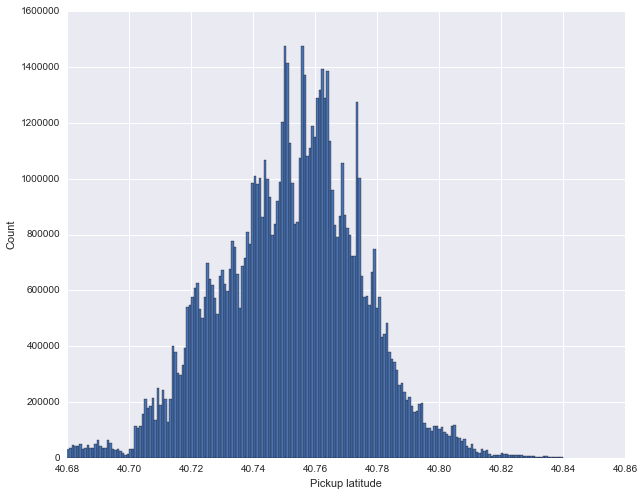

In [62]:
histBinsLa = np.linspace(40.68,40.84,200)
df['pickup_latitude'].hist(bins=histBinsLa)
plt.xlabel('Pickup latitude')
plt.ylabel('Count')

Joint histogram of longitude and latitude

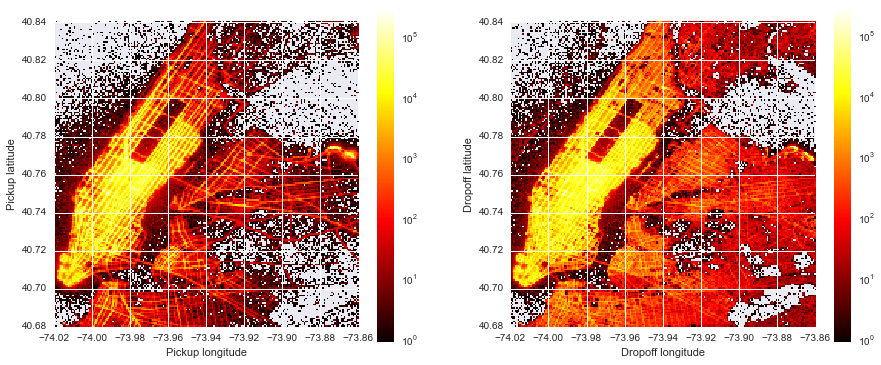

In [63]:
f, axs = plt.subplots(1,2,figsize=(15,6))
# Plot pickups
x = df['pickup_longitude'].values
y = df['pickup_latitude'].values
im1 = axs[0].hist2d(x,y,bins=[histBinsLo, histBinsLa],norm=matplotlib.colors.LogNorm(),cmap='hot')
axs[0].set_aspect('equal')
axs[0].set_xlabel('Pickup longitude')
axs[0].set_ylabel('Pickup latitude')
plt.axes(axs[0])
plt.colorbar(im1[3])

# Plot dropoffs
x = df['dropoff_longitude'].values
y = df['dropoff_latitude'].values
im2 = axs[1].hist2d(x,y,bins=[histBinsLo, histBinsLa],norm=matplotlib.colors.LogNorm(),cmap='hot')
axs[1].set_aspect('equal')
axs[1].set_xlabel('Dropoff longitude')
axs[1].set_ylabel('Dropoff latitude')
plt.axes(axs[1])
plt.colorbar(im2[3])

##Load weather data and take a look

In [64]:
weather_df = pd.read_pickle('../WEATHER/clean_weather.pkl')
weather_df.head()

,Number,Time,AbsoluteDay,Month,DayOfMonth,DayOfWeek,Hour,TemperatureF,PrecipitationIn,Humidity,SeaLevelPressureIn,VisibilityMPH,Conditions,WindSpeedMPH
0,0,2013-07-01 00:00:00,0,7,1,0,0,73.9,NaN,87,29.91,9,Clear,3.5
1,1,2013-07-01 01:00:00,0,7,1,0,1,75.0,NaN,84,29.92,8,Overcast,0.0
2,2,2013-07-01 02:00:00,0,7,1,0,2,75.0,NaN,84,29.92,8,Overcast,0.0
3,3,2013-07-01 03:00:00,0,7,1,0,3,73.9,NaN,87,29.91,8,Overcast,3.5
4,4,2013-07-01 04:00:00,0,7,1,0,4,73.9,NaN,87,29.91,9,Overcast,0.0


[]

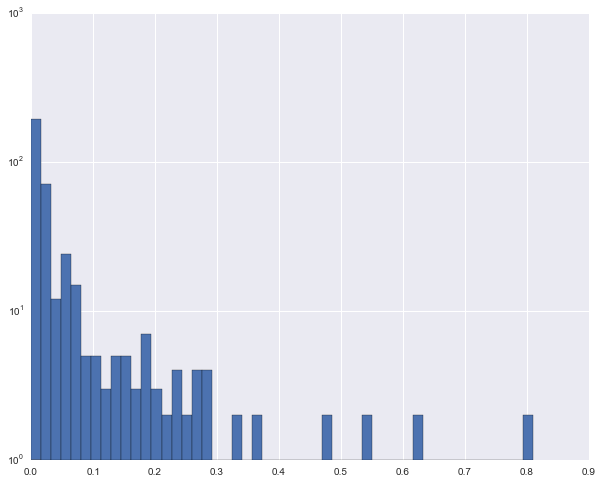

In [65]:
weather_df['PrecipitationIn'].hist(bins=50, bottom = 1)
plt.semilogy()

Rearrange the data to match the taxi dataset

In [66]:
weather_df['AbsoluteDay'] = weather_df['AbsoluteDay'] + 182 #to bring both dataframes to the same scale
weather_df.drop(['Time','Number'],axis=1,inplace=True) #don't need these
#make columns match in both dataFrames
weather_df.rename(columns={'AbsoluteDay':'pickup_day_of_year', 'Month':'pickup_month',
                           'DayOfMonth':'pickup_day_of_Month','DayOfWeek':'pickup_day_of_week',
                           'Hour':'pickup_hour'}, inplace=True)
weather_df['PrecipitationIn'].fillna(0, inplace=True) #I'm assuming NaNs are no percip
weather_df['rain'] = weather_df['Conditions'].map(lambda x: 'Rain' in x)

Merge the two data sets

In [67]:
joint_df = pd.merge(df, weather_df)

Make a dataFrame of only weekday data

In [68]:
weekday_df = joint_df[['pickup_day_of_year','passenger_count','trip_time_in_secs','trip_distance','pickup_hour','rain']][joint_df['pickup_day_of_week']<=5]

Group the data s.t. we have the average number of trips per hour (across days) separated into rainy and non-rainy days

In [69]:
grp = weekday_df.groupby(['pickup_hour', 'rain', 'pickup_day_of_year']).count() #the count will get us number of trips
grp.head()##you'll notice trip_distance doesn't match the other colums. this problem goes away if you change the data type to float

passenger_count  trip_time_in_secs  \
pickup_hour rain  pickup_day_of_year                                       
0           False 182                           12385              12385   
                  183                           11276              11276   
                  184                           13919              13919   
                  185                           19735              19735   
                  186                           18260              18260   

                                      trip_distance  
pickup_hour rain  pickup_day_of_year                 
0           False 182                         12384  
                  183                         11280  
                  184                         13920  
                  185                         19728  
                  186                         18256

In [70]:
grp.index = grp.index.droplevel(2) #don't really care about day of year
grp = grp.groupby(level=[0,1]).mean()
grp.head()

passenger_count  trip_time_in_secs  trip_distance
pickup_hour rain                                                    
0           False     16418.960526       16418.960526   16419.184211
            True      19346.166667       19346.166667   19344.000000
1           False     11427.619355       11427.619355   11427.587097
            True      13646.333333       13646.333333   13644.000000
2           False      8213.888889        8213.888889    8213.816993

In [71]:
tripCount = grp['passenger_count'].unstack()

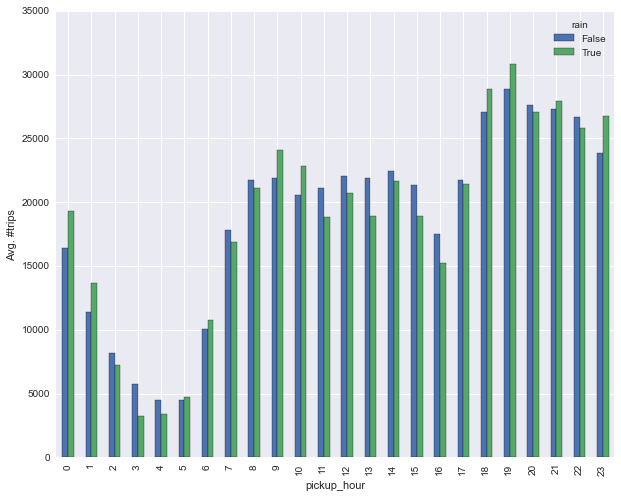

In [81]:
tripCount.plot(kind='bar')
plt.ylabel('Avg. #trips')

Look at the number of passengers on rainy and non rainy days

In [82]:
grp2 = weekday_df.groupby(['pickup_hour', 'rain']).mean() 
grp2.head()

pickup_day_of_year  passenger_count  trip_time_in_secs  \
pickup_hour rain                                                            
0           False          273.955984         1.741450         699.308808   
            True           265.843294         1.776019         729.074063   
1           False          272.336184         1.736036         660.498767   
            True           338.878893         1.753365         680.902636   
2           False          275.020062         1.734648         643.343823   

                   trip_distance  
pickup_hour rain                  
0           False       3.382812  
            True        3.306641  
1           False       3.314453  
            True        3.236328  
2           False       3.314453

In [83]:
grp2 = grp2.unstack()

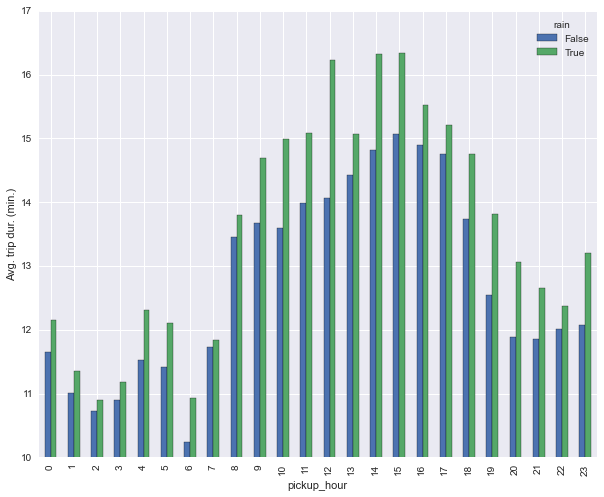

In [84]:
(grp2['trip_time_in_secs']/60).plot(kind='bar')
plt.ylim(10,17)
plt.ylabel('Avg. trip dur. (min.)')

Is there something special about 6AM that trips are shorther?

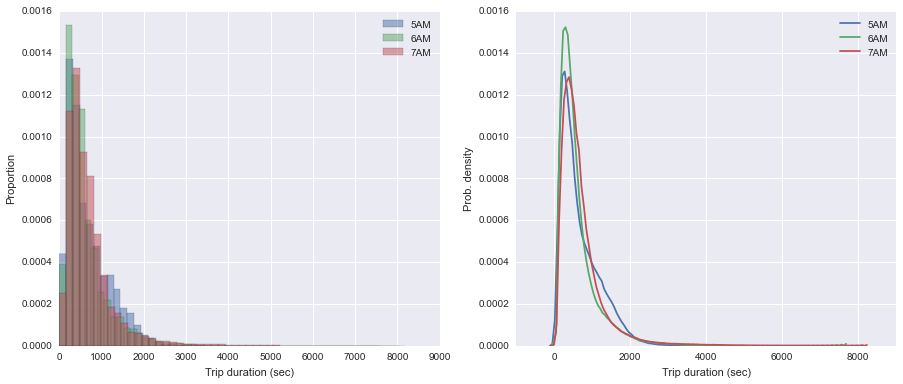

In [85]:
tmp = weekday_df[weekday_df['rain']==False]
f, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].hist(tmp['trip_time_in_secs'][tmp['pickup_hour']==5].values, bins=50, alpha=0.5, normed=True, label='5AM')
axs[0].hist(tmp['trip_time_in_secs'][tmp['pickup_hour']==6].values, bins=50, alpha=0.5, normed=True, label='6AM')
axs[0].hist(tmp['trip_time_in_secs'][tmp['pickup_hour']==7].values, bins=50, alpha=0.5, normed=True, label='7AM')
axs[0].legend()
axs[0].set_xlabel('Trip duration (sec)')
axs[0].set_ylabel('Proportion')

sns.distplot(tmp['trip_time_in_secs'][tmp['pickup_hour']==5].values, ax = axs[1], hist = False, label='5AM')
sns.distplot(tmp['trip_time_in_secs'][tmp['pickup_hour']==6].values, ax = axs[1], hist = False, label='6AM')
sns.distplot(tmp['trip_time_in_secs'][tmp['pickup_hour']==7].values, ax = axs[1], hist = False, label='7AM')
axs[1].legend()
axs[1].set_xlabel('Trip duration (sec)')
axs[1].set_ylabel('Prob. density')

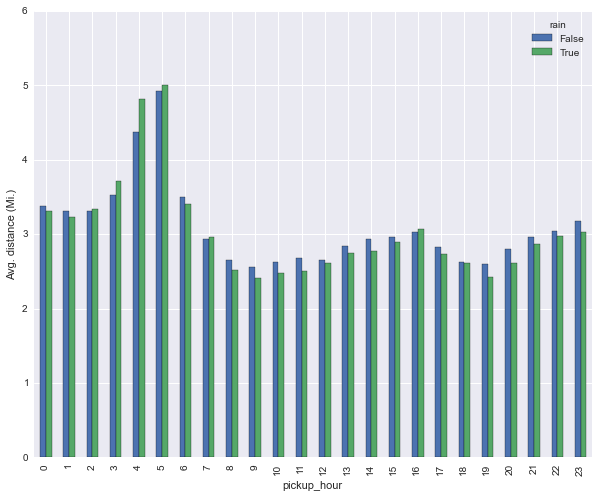

In [86]:
grp2['trip_distance'].plot(kind='bar')
plt.ylabel('Avg. distance (Mi.)')

Why are trips around 4-5AM ~two minutes longer on average

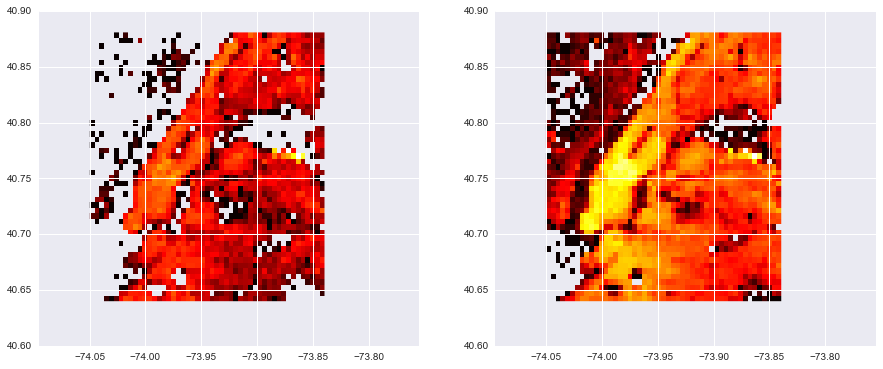

In [78]:
histBinsLo = np.linspace(-74.05,-73.84,50)
histBinsLa = np.linspace(40.64,40.88,50)
f, axs = plt.subplots(1,2,figsize=(15,6))
# 4-5 AM
x = df['dropoff_longitude']\
[(df['pickup_hour'].isin([4,5])) & (df['trip_distance']>10)].values

y = df['dropoff_latitude']\
[(df['pickup_hour'].isin([4,5])) & (df['trip_distance']>10)].values

axs[0].hist2d(x,y,bins=[histBinsLo, histBinsLa],norm=matplotlib.colors.LogNorm(),cmap='hot')
limits = axs[0].axis('equal')

# not 4-5AM
x = df['dropoff_longitude']\
[(~df['pickup_hour'].isin([4,5])) & (df['trip_distance']>10)].values

y = df['dropoff_latitude']\
[(~df['pickup_hour'].isin([4,5])) & (df['trip_distance']>10)].values

axs[1].hist2d(x,y,bins=[histBinsLo, histBinsLa],norm=matplotlib.colors.LogNorm(),cmap='hot')
limits = axs[1].axis('equal')

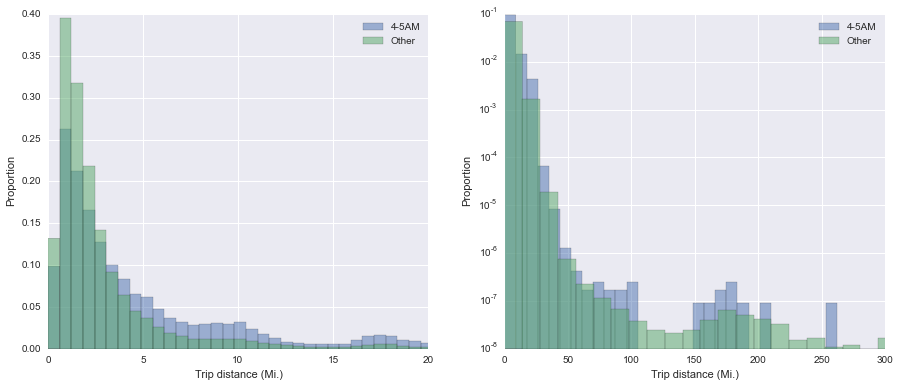

In [87]:
f, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].hist(weekday_df['trip_distance'][weekday_df['pickup_hour'].isin([4,5])].values,
            bins=np.linspace(0,30,50), alpha=0.5, normed=True, label='4-5AM')  
axs[0].hist(weekday_df['trip_distance'][~weekday_df['pickup_hour'].isin([4,5])].values,
            bins=np.linspace(0,30,50), alpha=0.5, normed=True, label='Other')
axs[0].legend()
axs[0].set_xlim(0,20)
axs[0].set_xlabel('Trip distance (Mi.)')
axs[0].set_ylabel('Proportion')

axs[1].hist(weekday_df['trip_distance'][weekday_df['pickup_hour'].isin([4,5])].values,
            bins=50, alpha=0.5, bottom=1e-8, normed=True, label='4-5AM')  
axs[1].hist(weekday_df['trip_distance'][~weekday_df['pickup_hour'].isin([4,5])].values,
            bins=50, alpha=0.5, bottom=1e-8,normed=True, label='Other')
axs[1].legend()
axs[1].semilogy()
axs[1].set_xlim(0,300)
axs[1].set_xlabel('Trip distance (Mi.)')
axs[1].set_ylabel('Proportion')

What are the dropoff locations 200 miles away from NYC?

In [88]:
longTrips = (df['trip_distance'] > 130) & (df['trip_distance'] < 230)

from math import radians, cos, sin, asin, sqrt
def haversine(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [row['pickup_longitude'], row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth 6371 for kilometers. 3956 for miles
    return c * r

birdDist = df[longTrips][['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].apply(haversine,axis=1)

In [89]:
mbox = folium.Map(location=[40.74, -73.99], tiles='MapQuest Open',
                    zoom_start=11)
pickLocations = df[longTrips][birdDist>50][['pickup_latitude','pickup_longitude']].values.tolist()
dropLocations = df[longTrips][birdDist>50][['dropoff_latitude','dropoff_longitude']].values.tolist()
locations = list(zip(pickLocations, dropLocations))
for loc in locations:
    mbox.circle_marker(location=[loc[0][0],loc[0][1]], radius=200, 
                       fill_color='red', line_color='red')
    mbox.circle_marker(location=[loc[1][0],loc[1][1]], radius=200, 
                       fill_color='blue', line_color='blue')                          
    
mbox.create_map(path='test_folium_map.html')
del mbox